In [1]:
from matplotlib import pyplot as plt
import numpy as np

from data.MNIST.mnist_csv_loader import load_data

In [2]:
%%time
train_x, train_y = load_data('../data/MNIST/csv/mnist_train.csv')
test_x, test_y = load_data('../data/MNIST/csv/mnist_test.csv')

CPU times: user 28 s, sys: 416 ms, total: 28.4 s
Wall time: 28.5 s


In [3]:
def normalize(x: np.ndarray) -> np.ndarray:
    min_v, max_v = np.min(x), np.max(x)
    return ((x + min_v) / (max_v - min_v)) * 2. - 1.

def one_hot(y: np.ndarray) -> np.ndarray:
    n, m = y.shape[0], int(y.max())+1
    rtn = np.zeros((n, m))
    rtn[range(n), y.reshape(n).astype('int')] = 1.
    return rtn

In [4]:
# prepare data
train_x = normalize(train_x)
train_y = one_hot(train_y)
test_x = normalize(test_x)
test_y = one_hot(test_y)

In [5]:
def get_accuracy(result, gt):
    return (np.argmax(result, axis=1) == np.argmax(gt, axis=1)).astype('float').sum() / float(gt.shape[0])

In [6]:
from src.model import Model
from src.cost import LogSoftmax, CrossEntropyWithSoftmax
from src.activation import Identity, ReLU

In [7]:
# build model
m = Model(learning_rate=.01, cost=CrossEntropyWithSoftmax).layer(28*28).layer(300, ReLU).layer(100, ReLU).layer(10, Identity)

In [8]:
cost, accuracy = m.train(
    train_set=(train_x, train_y),
    test_set=(test_x, test_y),
    batch_size=32,
    epochs=5,
    get_accuracy=get_accuracy
)

Training epoch 1: .........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Epoch training time: 27.05, validation accuracy: 0.9389
Training epoch 2: .........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Epoch training time: 21.36, validation accuracy: 0.9558
Training epoch 3: .........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Epoch training time: 21.54, validation accuracy: 0.9635
Training epoch 4: .........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Epoch training time: 21.81, validation accuracy: 0.9683
Training epoch 5: .........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Epoch training time: 21.72, validation accuracy: 0.9715
Total training time: 114.23, test accura

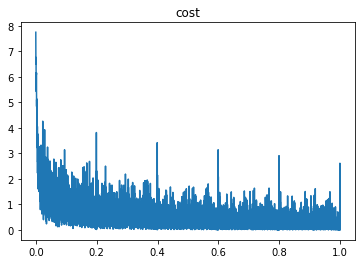

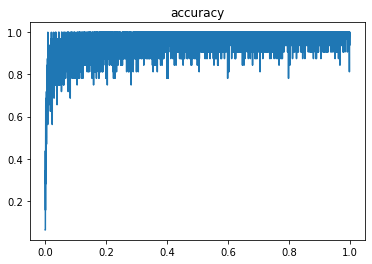

1.0


In [9]:
# plot cost and accuracy
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(cost)), np.array(cost))
ax.set_title('cost')
plt.show()
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,len(accuracy)), np.array(accuracy))
ax.set_title('accuracy')
plt.show()
print(accuracy[-1])

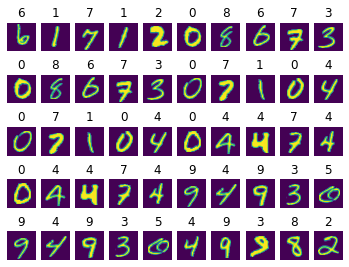

In [10]:
# randomly pick some test data points to give some intuitive proof
n, p = 10, 5
random_pick = test_x[np.random.choice(np.arange(test_x.shape[0]), n*p)]
result = m.inference(random_pick)
result_literal = np.argmax(result, axis=1)
fig, axs = plt.subplots(p, n)
for i in range(p):
    for j in range(n):
        # use prediction as title
        axs[i, j].set_title('{}'.format(result_literal[i*p+j]))
        axs[i, j].imshow(random_pick[i*p+j].reshape((28, 28)))
        axs[i, j].axis('off')
plt.subplots_adjust(top=1)
plt.show()